### Prophetでの株価予測モデルの精度検証とハイパーパラメータ最適化  
https://note.com/scilabcafe/n/n5fa75e8f25ef

Prophetで株価を予測する  
https://note.com/scilabcafe/n/n2302ae322277

rophetではチューニングできるパラメータ（ハイパーパラメータ）が多くあります。特に、各パラメータが大きい影響力を持っていて、値を少し変えただけでも予測値が大きく変化します。このハイパーパラメータを調整し最適な設定を探すタスクを、ハイパーパラメータチューニングと言います。  

ここでは、ハイパーパラメータチューニングをベイズ最適化で行う代表的なライブラリ Oputuna を使って、より良いハイパーパラメータの組合せを探索し、予測精度を比較したいと思います。

##### ライブラリをインポートして株価データを取得する  
時系列機械学習ライブラリである fbprophet から Prophet をインポートします。  
oputuna、mean_absolute_error、mean_squared_errorをインポートします。

In [20]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet
import optuna #  Preferred Networks社が開発しているハイパーパラメータの最適化を自動化するためのフレームワーク

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

[optuna tutorial]('https://optuna.readthedocs.io/en/stable/tutorial/index.html')

#### 株価データを取得してデータを確認  
下記を参考にOHLCV（始値 / 高値 / 安値 / 終値 / 出来高）形式の日経平均株価(^NKX)データを取得します。  
データの取得期間は、2018年1月1日から2023年6月/1日まで

In [2]:
start = '2018/01/01'
end = '2023/06/01'

df = web.DataReader('^NKX', 'stooq', start, end)
# 日付を昇順に並び替える
df.sort_index(inplace= True)
# インデックスをリセット
df = df.reset_index()

display(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1319 non-null   datetime64[ns]
 1   Open    1319 non-null   float64       
 2   High    1319 non-null   float64       
 3   Low     1319 non-null   float64       
 4   Close   1319 non-null   float64       
 5   Volume  1319 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 62.0 KB


None

,Date,Open,High,Low,Close,Volume
0,2018-01-04,23073.73,23506.33,23065.20,23506.33,1053914496
1,2018-01-05,23643.00,23730.47,23520.52,23714.53,1051263424
2,2018-01-09,23948.97,23952.61,23789.03,23849.99,970172096


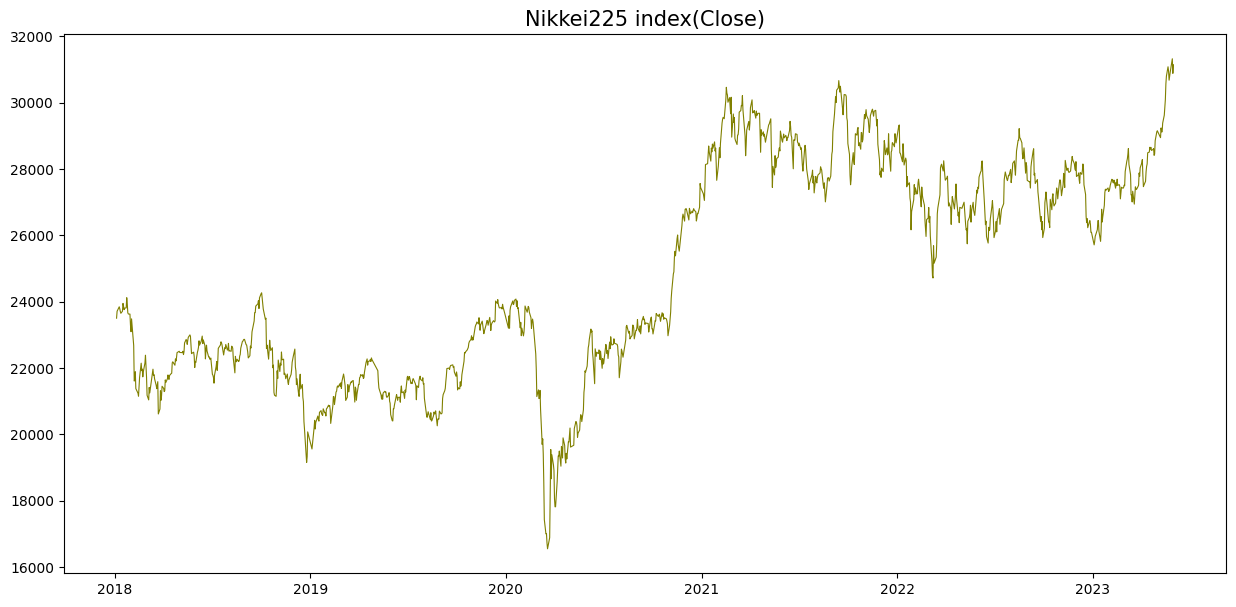

In [3]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(df['Date'], df['Close'], lw = 0.8, color = 'olive')
ax.set_title('Nikkei225 index(Close)', fontsize = 15)
plt.show()

#### 基礎分析をする  
まず、可視化して年、月、週の周期性がありそうか確認

In [4]:
# 年、月、週の周期性がありそうか確認するため、年、月、週、日カラムを追加

df['year'] = df.Date.apply(lambda x: x.year)
df['month'] = df.Date.apply(lambda x: x.month)
df['weekday'] = df.Date.apply(lambda x: x.dayofweek)
df['day'] = df.Date.apply(lambda x: x.day)

display(df.year[:4])
display(df.month[:4])
display(df.weekday[:4])
display(df.day[:4])

display(df.info())

0    2018
1    2018
2    2018
3    2018
Name: year, dtype: int64

0    1
1    1
2    1
3    1
Name: month, dtype: int64

0    3
1    4
2    1
3    2
Name: weekday, dtype: int64

0     4
1     5
2     9
3    10
Name: day, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1319 non-null   datetime64[ns]
 1   Open     1319 non-null   float64       
 2   High     1319 non-null   float64       
 3   Low      1319 non-null   float64       
 4   Close    1319 non-null   float64       
 5   Volume   1319 non-null   int64         
 6   year     1319 non-null   int64         
 7   month    1319 non-null   int64         
 8   weekday  1319 non-null   int64         
 9   day      1319 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 103.2 KB


None

年ごとに月、週、日の終値平均値を可視化

,Date,Open,High,Low,Close,Volume,year,month,weekday,day
1218,2023-01-04,25834.93,25840.68,25661.89,25716.86,833297500,2023,1,2,4
1219,2023-01-05,25825.50,25947.10,25750.46,25820.80,723092500,2023,1,3,5


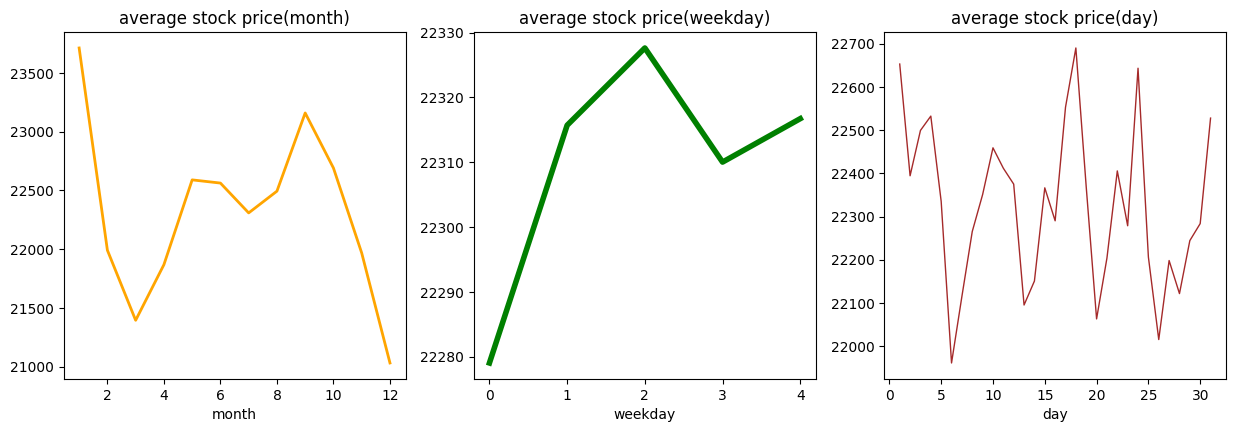

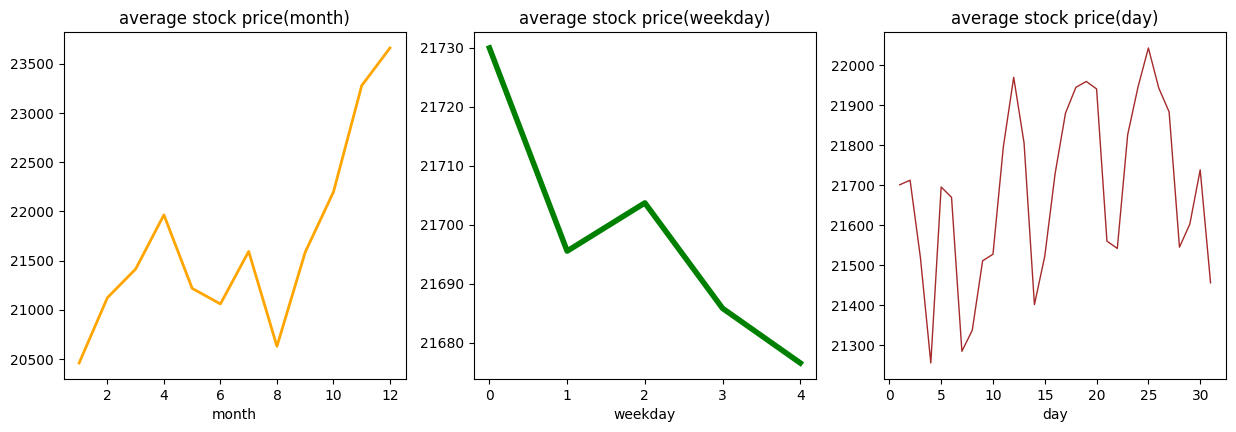

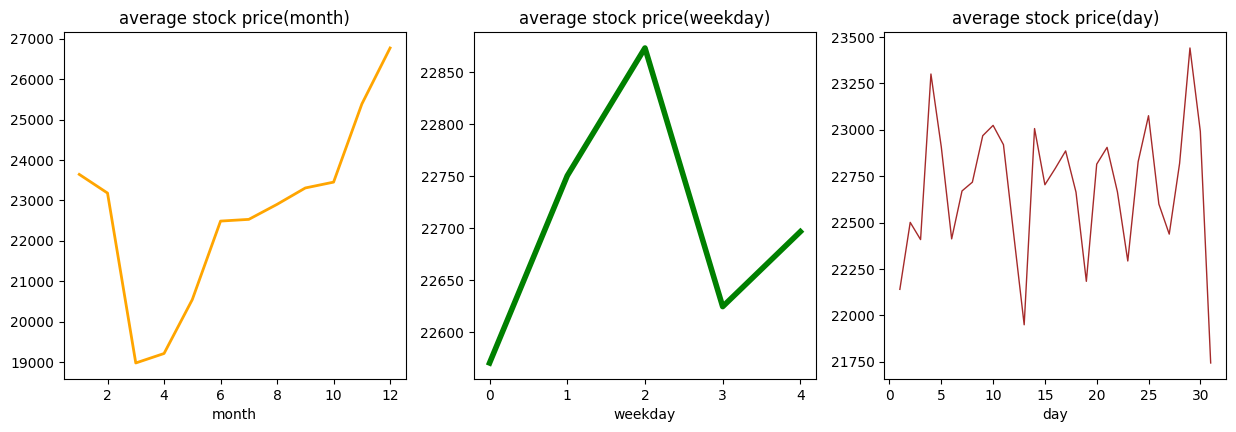

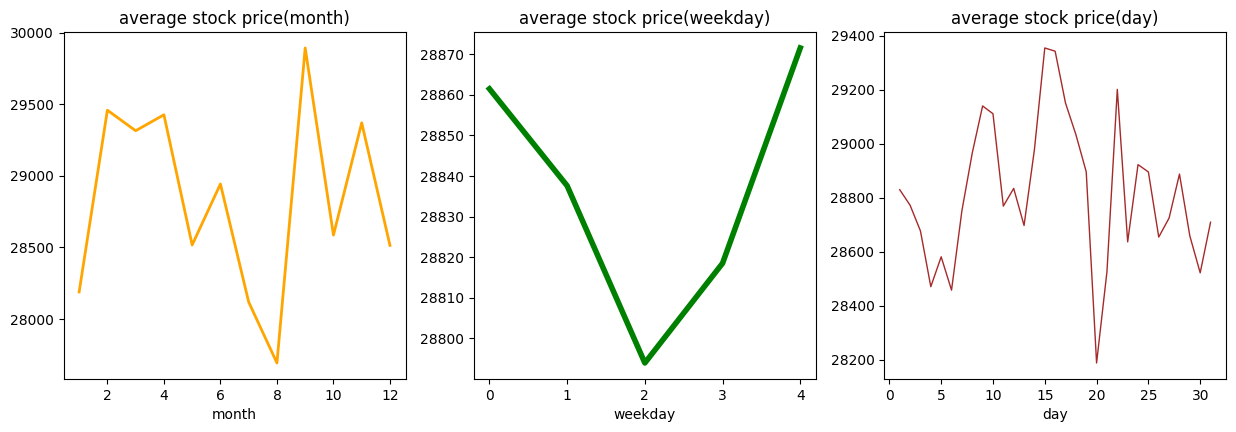

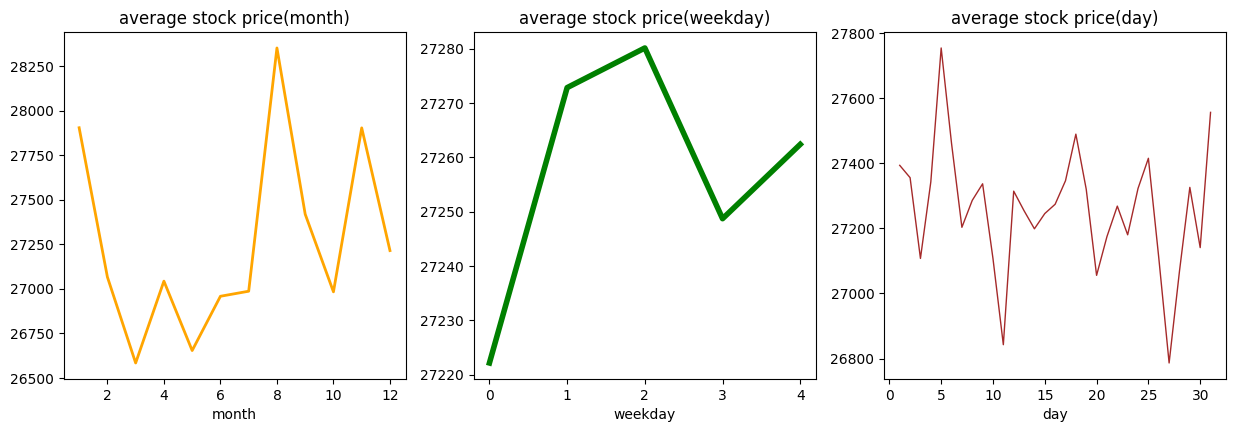

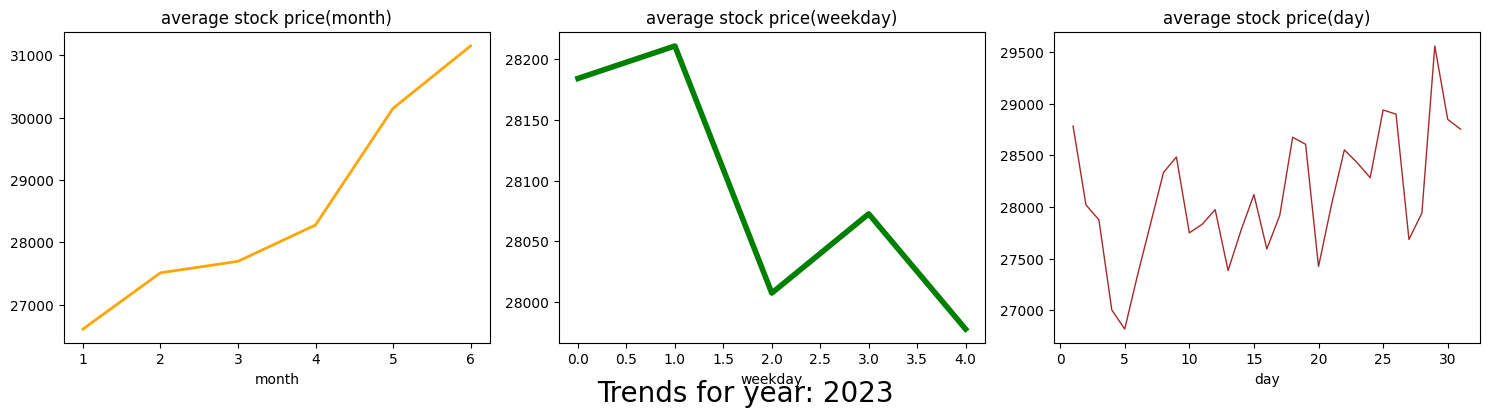

In [5]:
# 年ごとに月、週、日の終値平均値を可視化

for idx in list([2018,2019,2020,2021,2022,2023]): # same as [2018,2019,2020,2021,2022,2023]
    tmp_df = df[df.year == idx].copy()
    tmp_df.sort_values('Date', inplace = True)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 4.5))

    # 月平均値のグラフ化
    tmp_df.groupby('month').mean()['Close'].plot(kind = 'line', title = 'average stock price(month)', 
                                                lw = 2, color = 'orange', ax = ax1)
    # 週平均値のグラフ化
    tmp_df.groupby('weekday').mean()['Close'].plot(kind = 'line', title='average stock price(weekday)',
                                                lw =4, color = 'green', ax = ax2)

    # 日平均値のグラフ化
    tmp_df.groupby('day').mean()["Close"].plot(color = 'brown', ax = ax3, 
                                            title='average stock price(day)', lw = 1)

fig.suptitle('Trends for year: {0}'.format(idx), size = 20, y = 0.05)
plt.tight_layout()

display(tmp_df.head(2))
plt.show()

2018年から2023年まで総合的に見た場合、明確な周期性はなさそうです。

### Prophetで予測する 
今回は、以下の条件で株価予測を行います。  

- 対象：日経平均株価(^NKX)  

- 学習期間：2018/1/1～2023/1/1  

- 予測期間：2023/1/1以降、2023/6/1までの終値を予測



##### デフォルトパラメータでの予測と精度検証 
Prophetを用いるため、ds カラムと y カラムを追加し、train データと testデータに分割して確認のためグラフを描画します。  
trainデータセット（df_train）は青で、testデータセット（df_test）は橙で描かれており、2023年以降は、df_test になっておりデータが分割できていることが確認できます。

In [6]:
# 新たに ds列と y列を追加
df['ds'] = df.Date
df['y'] = df.Close
display(df.head(2))

# trainデータとtestデータに分割
df_train = df[df['ds'] < '2023-01-01']
display(df_train.tail(1))
df_test = df[df['ds'] >= '2023-01-01']
display(df_test.head(2))

print(f'ratio train and test = {len(df_train) / len(df)}')

,Date,Open,High,Low,Close,Volume,year,month,weekday,day,ds,y
0,2018-01-04,23073.73,23506.33,23065.20,23506.33,1053914496,2018,1,3,4,2018-01-04,23506.33
1,2018-01-05,23643.00,23730.47,23520.52,23714.53,1051263424,2018,1,4,5,2018-01-05,23714.53


,Date,Open,High,Low,Close,Volume,year,month,weekday,day,ds,y
1217,2022-12-30,26288.0,26321.37,26067.92,26094.5,527361300,2022,12,4,30,2022-12-30,26094.5


,Date,Open,High,Low,Close,Volume,year,month,weekday,day,ds,y
1218,2023-01-04,25834.93,25840.68,25661.89,25716.86,833297500,2023,1,2,4,2023-01-04,25716.86
1219,2023-01-05,25825.50,25947.10,25750.46,25820.80,723092500,2023,1,3,5,2023-01-05,25820.80


ratio train and test = 0.9234268385140257


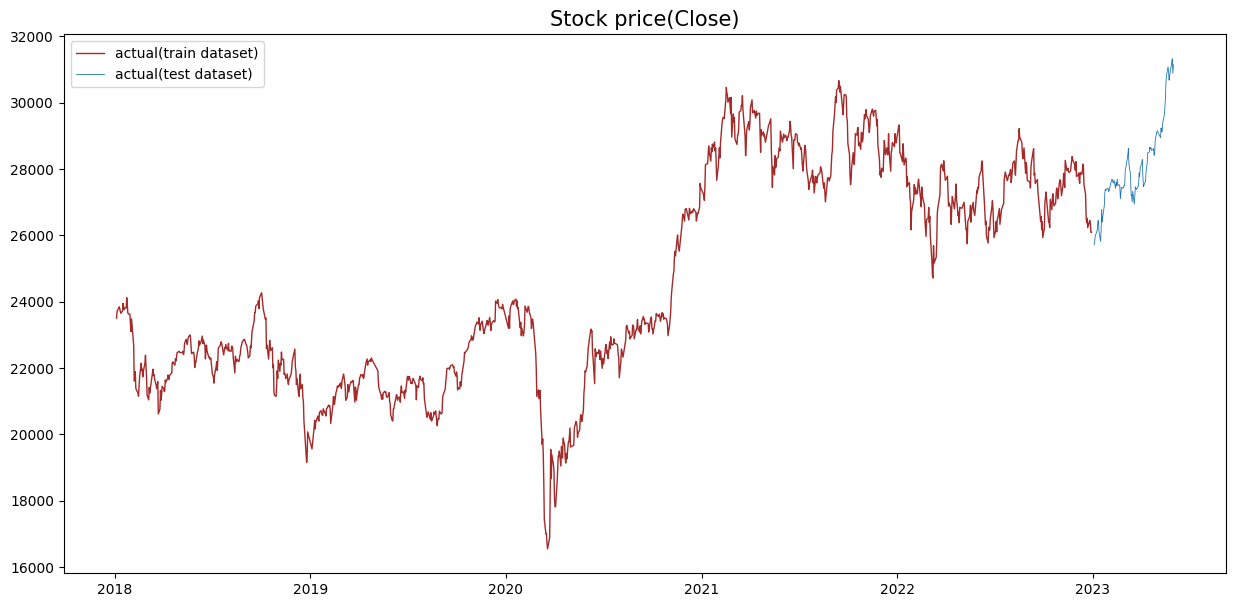

In [7]:
#　株価データを可視化
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_train.ds, df_train.y, label="actual(train dataset)", lw = 1, color = 'brown')
ax.plot(df_test.ds, df_test.y, label="actual(test dataset)", lw = 0.6)
ax.set_title("Stock price(Close)",fontsize=15)
plt.legend()
plt.show()

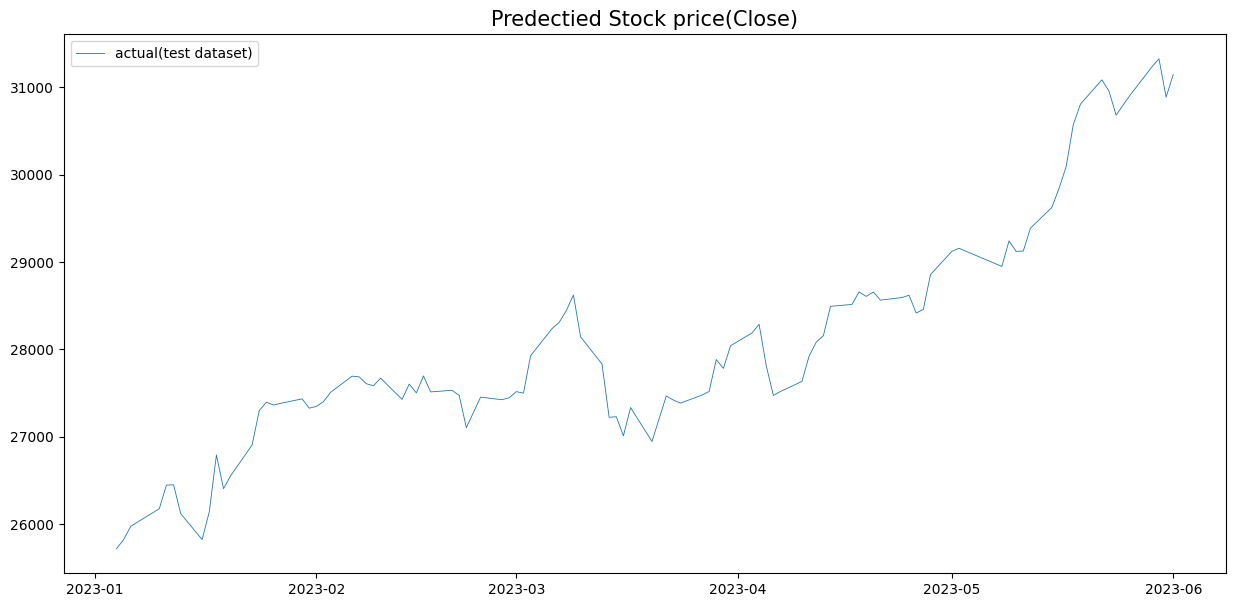

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_test.ds, df_test.y, label="actual(test dataset)", lw = 0.6)
ax.set_title("Predectied Stock price(Close)",fontsize=15)
plt.legend()
plt.show()

予測モデルを構築し、test 期間を含めて予測します。そして予測値と実測値からProphetモデルを評価します。  
 評価には、RMSE、MAE、MAPEという指標を使います。

・RMSE（Root Mean Squared Error）  
予測値と実測値の誤差を二乗して平均し、平方根をとった値です。MSEに平方根をつけたバージョンです。RMSEは予測値と実測値の誤差の大きさを表す指標で、二乗を取るため、大きな誤差がある場合はその影響が大きく出ます。RMSEが小さいほど、予測精度が高いと言えます。MSEを損失関数として使って，RMSEを評価指標として使うことも多いです。  
 
・MAE（Mean Absolute Error）  
予測値と実測値の誤差の絶対値を平均した値です。MAEは予測値と実測値の誤差の大きさを表す指標で、二乗を取らないため、大きな誤差があっても影響が小さくなります。MAEが小さいほど、予測精度が高いと言えます。  

・MAPE（Mean Absolute Percentage Error）  
予測値と実測値の差を実測値で割った値（パーセント誤差）の絶対値を平均した値です。MAPEは、予測値と実測値の相対的な誤差を表す指標で、予測値が小さい場合や0の場合には使用できません。100％の確率値にするため、一般的には最後に100をかけます。MAPEが小さいほど、予測精度が高いと言えます。



In [21]:
# 予測モデル構築
m = Prophet()
m.fit(df_train)

# 予測の実施（学習期間＋テスト期間）
df_future = m.make_future_dataframe(periods=len(df_test))
df_pred = m.predict(df_future)

# 元のデータセットに予測値を結合
df['Predict'] = df_pred['yhat']

# 予測精度（テストデータ期間）
## 予測値と実測値
preds = df.iloc[len(df_train):].loc[:, 'Predict']
y = df.iloc[len(df_train):].loc[:, 'y']

## 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y, preds)))
print('-----------------')

print('MAE:')
print(mean_absolute_error(y, preds))
print('-----------------')

print('MAPE(%):')
print(np.mean(abs(y - preds)/y)*100)

20:00:45 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE:
2329.6721185866504
-----------------
MAE:
1742.3478039631366
-----------------
MAPE(%):
6.010324700230368


最後にグラフを描画して予測時と実測値を比較します。

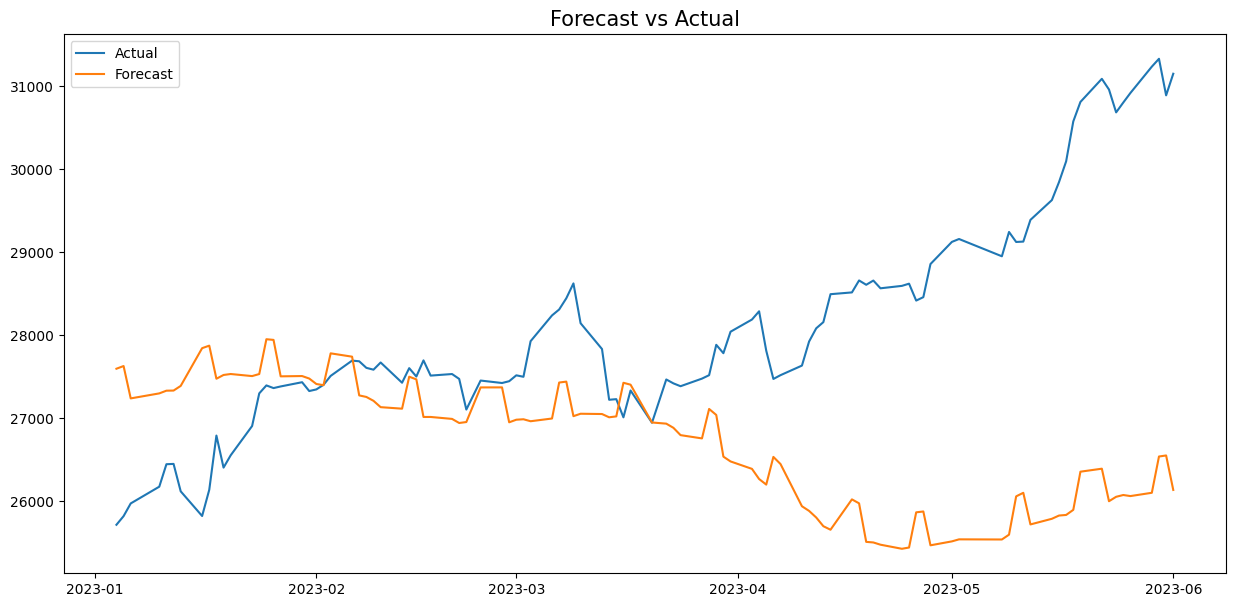

In [22]:
#　株価データを可視化
fig, ax = plt.subplots(figsize=(15,7))

# テスト期間の実測値と予測値を描画
ax.plot(df.iloc[len(df_train):]['Date'], df.iloc[len(df_train):]['y'], label="Actual")
ax.plot(df.iloc[len(df_train):]['Date'], df.iloc[len(df_train):]['Predict'], label="Forecast")
ax.set_title("Forecast vs Actual",fontsize=15)

plt.legend()
plt.show()

In [9]:
start = '2023/01/01'
end = '2023/06/01'

df_actual = web.DataReader('^NKX', 'stooq', start, end)
# 日付を昇順に並び替える
df_actual.sort_index(inplace= True)
# インデックスをリセット
df_actual = df_actual.reset_index()

display(df_actual.head(2))

,Date,Open,High,Low,Close,Volume
0,2023-01-04,25834.93,25840.68,25661.89,25716.86,833297500
1,2023-01-05,25825.50,25947.10,25750.46,25820.80,723092500


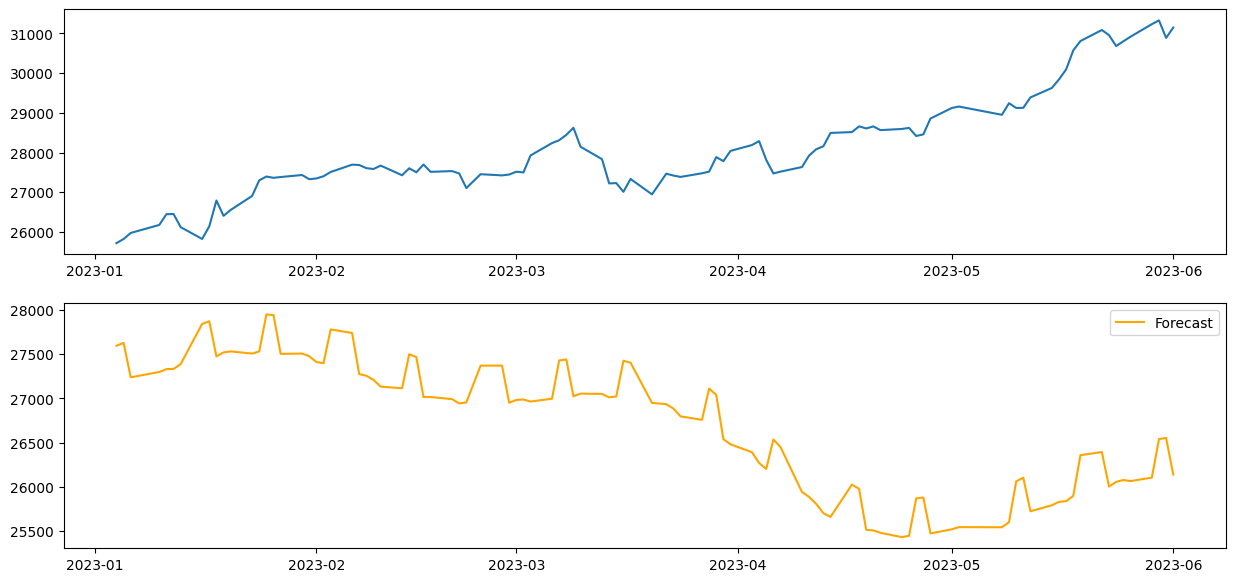

In [25]:
#　株価データを可視化
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))

# テスト期間の実測値と予測値を描画
ax1.plot(df.iloc[len(df_train): ]['Date'], df.iloc[len(df_train): ]['y'], label = "Actual")
ax2.plot(df.iloc[len(df_train): ]['Date'], df.iloc[len(df_train): ]['Predict'], label = "Forecast", color = 'orange')
ax.set_title("Forecast vs Actual",fontsize = 15)

plt.legend()
plt.show()

### Optunaによるパラメータチューニング  
Optunaでハイパーパラメータをチューニングします。まずは、以下の手順で最適パラメータの探索します。  

- 目的関数の設定  

- ハイパーパラメータの探索の実施  

- 最適パラメータの出力  

・changepoint_prior_scale
Prophetのハイパーパラメータの1つで最も影響力のあるパラメータです。時系列データの変化点を検出する際の柔軟性を調整するためのスケーリングパラメータです。このパラメータの値が大きいほど、モデルはより柔軟になり、小さい値の場合はより制限されます。[0.001, 0.5]の範囲がほぼ正しいでしょう。

・seasonality_prior_scale
Prophetのハイパーパラメータの1つで、季節性の柔軟性を制御します。値が大きいと季節性が大きな変動に適合し、値が小さいと季節性の大きさが小さくなります。デフォルトは 10 で、基本的に正則化は適用されません。調整の妥当な範囲はおそらく [0.01, 10] です。

・seasonality_mode
Prophetのハイパーパラメータの1つで、季節性のモードを指定するパラメータです。オプションは [ ‘additive’、’multiplicative’] です。デフォルト‘additive’です。additiveは季節性が加算され、multiplicativeは乗算されます。

・changepoint_range
Prophetのハイパーパラメータの1つで、変化点を検出する期間を制限するパラメータです。このパラメータの値が小さいほど、モデルは変化点をより早く検出するようになります。このパラメーターは、おそらく多数の時系列を除いて、調整しないほうがよいでしょう。設定では、[0.8, 0.95]が妥当な範囲かもしれません。

・n_changepoints
Prophetのハイパーパラメータの1つで、変化点の数を指定するパラメータです。このパラメータの値が大きいほど、モデルはより多くの変化点を検出するようになります。

目的関数を設定し、ハイパーパラメータの探索を実施して最適なパラメータを出力します。

In [27]:

def objective(trial):
    '''
    目的関数の設定
    '''
    params = dict({
        'changepoint_prior_scale' : trial.suggest_uniform('changepoint_prior_scale', 0.001,0.5),
        'seasonality_prior_scale' : trial.suggest_uniform('seasonality_prior_scale', 0.01,10),
        'seasonality_mode' : trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_range' : trial.suggest_discrete_uniform('changepoint_range', 0.8, 0.95, 0.001),
        'n_changepoints' : trial.suggest_int('n_changepoints', 20, 35),
    })
    
    m = Prophet(**params)
    m.fit(df_train)
    
    df_future = m.make_future_dataframe(periods=len(df_test), freq='D')
    df_pred = m.predict(df_future) 
    preds = df_pred.tail(len(df_test))
    val_rmse = np.sqrt(mean_squared_error(df_test.y, preds.yhat))
    return val_rmse

In [32]:
# 目的関数の最適化を実行する
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


# 最適パラメータの出力
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

[I 2024-05-22 20:12:58,390] A new study created in memory with name: no-name-7073f8b6-b9f6-45ed-b80a-c28687f84392
/tmp/ipykernel_8986/809684584.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'changepoint_prior_scale' : trial.suggest_uniform('changepoint_prior_scale', 0.001,0.5),
/tmp/ipykernel_8986/809684584.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'seasonality_prior_scale' : trial.suggest_uniform('seasonality_prior_scale', 0.01,10),
/tmp/ipykernel_8986/809684584.py:9: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'changepoin

The best value is : 
 921.4286761062839
The best parameters are : 
 {'changepoint_prior_scale': 0.37398693467699284, 'seasonality_prior_scale': 0.19328364169779588, 'seasonality_mode': 'additive', 'changepoint_range': 0.894, 'n_changepoints': 20}


上記の最適化したパラメータを設定して予測と構築したProphetモデルを評価します。  
 評価には、RMSE、MAE、MAPEという指標を使います。

In [33]:
# 最適パラメータで予測モデル構築
m = Prophet(**study.best_params)
m.fit(df_train)

# 予測の実施（学習期間＋テスト期間）
df_future = m.make_future_dataframe(periods = len(df_test))
df_pred = m.predict(df_future)

# 元のデータセットに予測値を結合
df['Predict'] = df_pred['yhat']

# 予測精度（テストデータ期間）
## 予測値と実測値
preds = df.iloc[len(df_train):].loc[:, 'Predict']
y = df.iloc[len(df_train):].loc[:, 'y']

## 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y, preds)))
print('-----------------')

print('MAE:')
print(mean_absolute_error(y, preds))
print('-----------------')

print('MAPE(%):')
print(np.mean(abs(y - preds) / y) * 100)

20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE:
921.4286761062839
-----------------
MAE:
698.3851805254812
-----------------
MAPE(%):
2.4317394726746144


最後にグラフを描画して予測時と実測値を比較します。

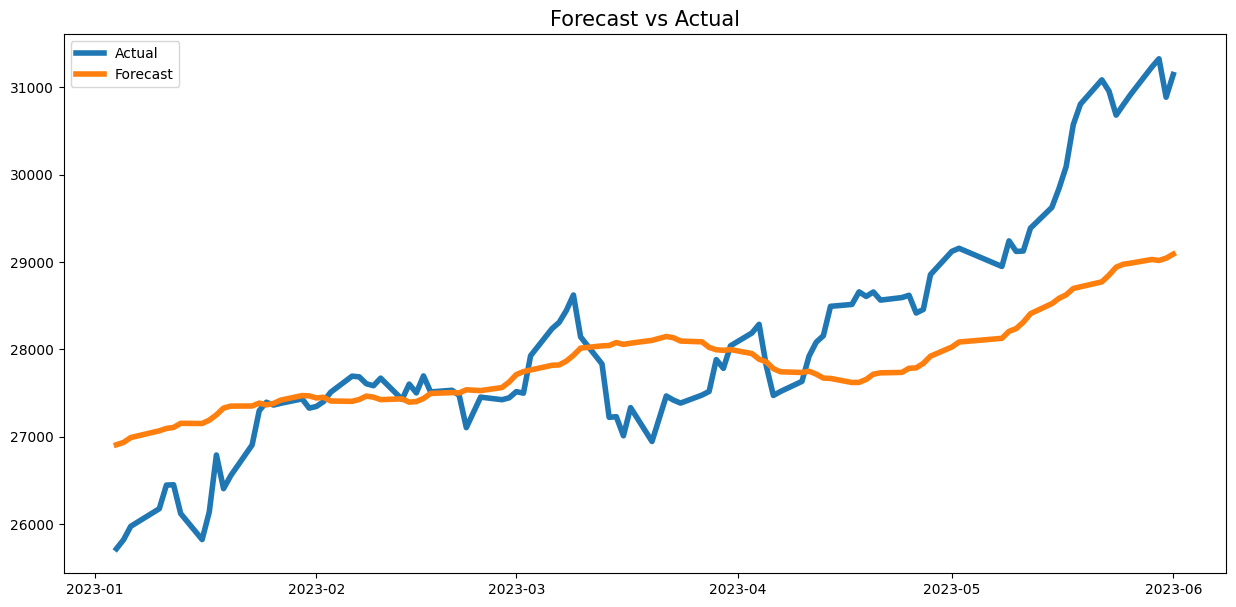

In [34]:
#　株価データを可視化
fig, ax = plt.subplots(figsize=(15,7))

# テスト期間の実測値と予測値を描画
ax.plot(df.iloc[len(df_train):]['Date'], df.iloc[len(df_train):]['y'], label="Actual", lw=4)
ax.plot(df.iloc[len(df_train):]['Date'], df.iloc[len(df_train):]['Predict'], label="Forecast", lw=4)
ax.set_title("Forecast vs Actual",fontsize=15)

plt.legend()
plt.show()

Optunaでハイパーパラメータを最適化することで、RMSE、MAE、MAPEの値が小さくなっており、精度が向上していることが確認できました。  
CV（クロスバリデーション）を合わせた Optuna による最適化については、別の投稿で取り上げていきたいと考えています。